In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
lagged = pd.read_csv('lagged_final')

In [3]:
lagged.columns

Index(['Unnamed: 0', 'shop_id', 'item_id', 'date_block_num', 'avg_item_price',
       'item_cnt_month', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'month', 'year', 'super_category', 'city',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_11',
       'item_cnt_month_lag_12', 'avg_item_price_lag_1', 'avg_item_price_lag_2',
       'avg_item_price_lag_3', 'avg_item_price_lag_4', 'avg_item_price_lag_5',
       'avg_item_price_lag_11', 'avg_item_price_lag_12', 'shop_id_cat',
       'item_id_cat', 'item_category_id_cat', 'first_date_block_num',
       'first_cat_block_num', 'first_sup_cat_block_num',
       'item_cnt_monthshop_id_item_category_name_lag_1',
       'item_cnt_monthshop_id_item_category_name_lag_2',
       'item_cnt_monthshop_id_item_category_name_lag_3',
       'avg_item_priceshop_id_item_category_name_lag_1',
       'avg_item_priceshop_id_ite

In [4]:
first_index_block_3 = lagged[lagged['date_block_num'] == 3 ].index[0]

In [5]:

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

# Assuming 'df' is your DataFrame
c1=0
c2=0
# Function to apply KNN and compute the weighted mean for item_cnt_month
def knn_weighted_mean(df, group_cols, target_col=None, price_col=None, date_block_num_col=None, n_neighbors=5,window_size=3):
    """
    window_size - in which date block nums to search for nearest neigbours
    """
    global c1
    global c2
    # Initialize a column for storing the results
    
    
    #results=pd.DataFrame(np.nan, index = np.arange(len(df)), columns = ['A'])
    # Iterate through each unique date_block_num (k)
    #to_predict = df.iloc[first_index_block_3:]
    
    results = np.full(len(df), np.nan)
    
    for date_block_num_k in df[date_block_num_col].unique():
        
        # Filter the data to include only rows with date_block_num < k and ( date_block_num_k - df[date_block_num_col] ) <= window_size
        #print(date_block_num_k - df[date_block_num_col] )
        prev  = df[ (df[date_block_num_col] < date_block_num_k) & \
        (( date_block_num_k - df[date_block_num_col] ) <= window_size) & \
        (df['date_block_num_diff'] >=2)]
        if len(prev)==0:
            #results[mask]=np.nan
            c1+=1
            #print('No previous blocks')
            continue
        
        # Apply grouping criteria and filter for group-specific calculations
        for group_val in df[group_cols].drop_duplicates().values:
            
            mask = (prev[group_cols] == group_val).all(axis=1) & \
            (~ np.squeeze (np.array(( np.isnan(prev[price_col ]) ))))
            
            pred_mask = ((df[group_cols] == group_val).all(axis=1)) & \
            (df['date_block_num']==date_block_num_k)  & \
            (~ np.squeeze (np.array(( np.isnan(df[price_col ]) ))))
            
            X = prev.loc[mask, [price_col]].values
            
            y = prev.loc[mask, target_col].values

            X_test=pd.DataFrame( df[pred_mask][price_col] ).values
            
            if len(X) == 0:
                c1+=1
                #print('ema is nan')
                continue

            if len(X) < n_neighbors:
                c1+=1
                results[pred_mask] = y.mean()
                #print('not enough neighb, avg')
                
                #print('X < n_neighbors')
                continue

            if len(X_test) == 0:
                c1+=1
                #print('no such in test')
                continue

            
            knn = KNeighborsRegressor(n_neighbors=n_neighbors)#, weights='distance'
            knn.fit(X, y)

            
            

            #print(results[pred_mask])
            results[pred_mask] = knn.predict( X_test )
            c2+=1
        print('block proc:',date_block_num_k)
    
    return results


In [6]:
group_cols=['item_category_name']
price_nb_cat = knn_weighted_mean(lagged[first_index_block_3:],
                                group_cols=['item_category_name'],
                                target_col='item_cnt_month', 
                                price_col= f'ema_avg_item_price_{'_'.join(group_cols)}',
                                date_block_num_col='date_block_num',
                                n_neighbors=20,
                                window_size=4
)#takes time
print('!!!!!!!!!!3rd processed...!!!!!!!')

KeyboardInterrupt: 

In [ ]:
lagged['price_nb_cat'] = np.empty(len(lagged))
lagged['price_nb_cat'].iloc [:first_index_block_3] = np.nan
lagged['price_nb_cat'].iloc [first_index_block_3:]=price_nb_cat

In [ ]:
group_cols=['item_category_name']
price_nb_cat = knn_weighted_mean(lagged[first_index_block_3:],
                                group_cols=['city','item_category_name'],
                                target_col='item_cnt_month', 
                                price_col= f'ema_avg_item_price_{'_'.join(group_cols)}',
                                date_block_num_col='date_block_num',
                                n_neighbors=20,
                                window_size=4
)#takes time
print('!!!!!!!!!!3rd processed...!!!!!!!')

In [ ]:
lagged['price_nb_city_cat'] = np.empty(len(lagged))
lagged['price_nb_city_cat'].iloc [:first_index_block_3] = np.nan
lagged['price_nb_city_cat'].iloc [first_index_block_3:]=price_nb_cat

In [ ]:
print(c1,c2)

In [ ]:
def choose_previos_blocks(data_SORTED, idx):
    #idx - idx in data_SORTED
    block = data_SORTED.iloc[idx]['date_block_num']
    last_index_block = blocks[block-1]
    return data_SORTED.iloc[0:last_index_block]

In [ ]:
blocks = [lagged[lagged['date_block_num'] == block-1 ].index[-1] for block in np.sort(lagged.date_block_num.unique())[1:]]

In [ ]:
a=0
b=0
c=0
d=0
e=0
def make_prediction_median(medians):
    new_cat_shop, new_cat_city, new_cat, new_sup_cat_city, sup_cat=medians
    #print(new_cat_shop, new_cat_city, new_cat, new_sup_cat_city, sup_cat)
    if new_cat_shop is not None and not np.isnan(new_cat_shop):
        global a
        a+=1
        #print(new_cat_shop, new_cat_city, new_cat, new_sup_cat_city, sup_cat)
        sales=new_cat_shop
    elif new_cat_city is not None  and not np.isnan(new_cat_city):
        global b
        b+=1
        sales = new_cat_city
    elif new_cat is not None  and not np.isnan(new_cat):
        global c
        c+=1
        sales = new_cat
    elif new_sup_cat_city is not None and not np.isnan(new_sup_cat_city):
        global d
        d+=1
        sales = new_sup_cat_city
    elif sup_cat is not None  and not np.isnan(sup_cat):
        global e
        e+=1
        sales = sup_cat
    else:
        sales=1 #bad, but...
    #print(sales)
          
    assert (not np.isnan(sales)) and (sales is not None)
    return sales

In [ ]:
def predict_EMA(row):
        #skipped (shop_id,item_id)
        #print(row)
        if not np.isnan(row['ema_item_cnt_month_item_id']) and row['ema_item_cnt_month_item_id'] is not None:#predict on item_id
            sales = row['ema_item_cnt_month_item_id']
            
        elif not np.isnan(row['ema_item_cnt_month_shop_id_item_category_name'])  and row['ema_item_cnt_month_shop_id_item_category_name'] is not None:   #predict on category, shop
            sales = row['ema_item_cnt_month_shop_id_item_category_name']
        elif not np.isnan(row['ema_item_cnt_month_item_category_name']):
            #row['ema_item_cnt_month_item_category_name'] is not None:#predict on category
            sales = row['ema_item_cnt_month_item_category_name']
        else:
            sales = row['ema_item_cnt_month_super_category']#may be nan - Билеты
            if np.isnan(sales):# better to handle, but..
                print(row)
                sales=1
        
        assert (not np.isnan(sales) )and (sales is not None)
        return sales

In [ ]:
def predict_by_knn_price(row):
    return row['price_nb_cat'] 


In [ ]:

#print(lagged.iloc[idx_range[1] + first_index_block_3])
def manual_preds(data, alpha1=1, alpha2=1):
    c1=0
    c2=0
    preds = []
    data['date_block_num_diff'] = data['date_block_num'] - data['first_date_block_num']#per ID
    data['cat_diff'] = data['date_block_num'] - data['first_cat_block_num']
    data['super_cat_diff'] = data['date_block_num'] - data['first_sup_cat_block_num']
    #print(data['super_cat_diff'])
    global idx_range
    for idx in range(first_index_block_3+idx_range[0],first_index_block_3+idx_range[1]):
        #sales = None
        row = data.iloc[idx]
        prev = choose_previos_blocks(data,idx)

        #HAVE info for last 3 monthe for item_id(independent from shop)
        #sales=predict_EMA(row)
        #preds.append(sales)
        
        price_pred = predict_by_knn_price(row)
        
        if row['date_block_num_diff'] > 2:#can make preds based on EMA (it may be improved with city, super_category)
            c1+=1
            if np.isnan(price_pred):
                sales= predict_EMA(row)
            else:
                sales= alpha1 * predict_EMA(row) + (1-alpha1)*price_pred #each here have ema by category
            
        #NO info for last 3 monthes for item_id(independent from shop)
        else:
            c2+=1
            #medians=calculate_median(row,prev)#may be precompute here
            medians = row[['new_cat_shop_avg', 'new_cat_city_avg', 'new_cat_avg', 'new_sup_cat_city_avg', 'sup_cat_avg']]

            if np.isnan(price_pred):
                sales = make_prediction_median(medians)
            else:
                sales = alpha2 *  make_prediction_median(medians) + (1 - alpha2) * price_pred#each here have ema by category
            
            
            
            
        assert   not np.isnan(sales) and sales is not None
        preds.append(sales)
        
        
    print(c1,c2)
    
    return  preds
    

In [ ]:
idx_range = [0,len(lagged)-first_index_block_3 - 1]
#idx_range = [500000,600000]

In [ ]:
preds=manual_preds(lagged, alpha1=0.7, alpha2=1)

In [34]:
sales_pred_true = pd.DataFrame({ 'pred':preds, 'true':lagged[first_index_block_3+idx_range[0]:first_index_block_3+idx_range[1]] ['item_cnt_month']})

In [35]:
from sklearn.metrics import mean_squared_error

count    1.421192e+06
mean    -5.458399e-02
std      7.976215e+00
min     -2.081571e+03
25%     -2.600733e-02
50%      2.142857e-01
75%      6.365141e-01
max      8.127143e+02
dtype: float64
rmse 6.0037769534512515


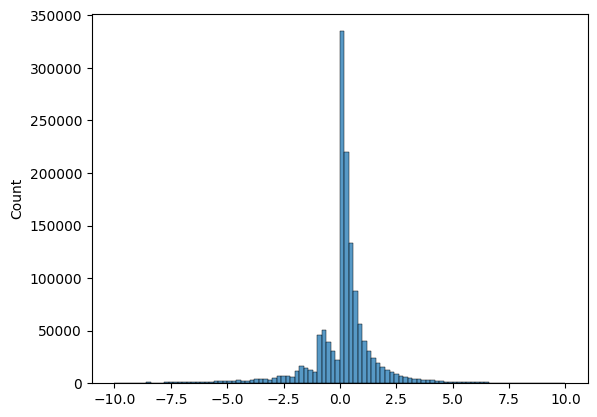

In [36]:
print((sales_pred_true['pred'] - sales_pred_true['true']).describe())
sns.histplot(sales_pred_true['pred'] - sales_pred_true['true'], binrange=[-10,10], bins=100)
print('rmse',mean_squared_error(np.clip(sales_pred_true['true'],0,20),np.clip(sales_pred_true['pred'],0,20)))

In [106]:
sales_pred_true[['pred','true']] [abs(sales_pred_true['pred'] - sales_pred_true['true']) >50]

,pred,true
187231,3.082817,83.0
187940,3.082817,175.0
188496,3.360061,59.0
188787,3.074508,88.0
190051,72.000000,13.0
...,...,...
1605878,2.726190,75.0
1607171,84.769878,23.0
1607181,84.769878,19.0
1607249,84.769878,3.0


In [ ]:
lagged.iloc[975139]['super_category']

In [77]:
lagged[lagged['super_category'] == 'Билеты'].date_block_num.unique()

array([18, 19, 20, 21, 27, 28, 29, 30, 31, 32])

In [64]:
s = lagged.query('item_id== 9243')[['date_block_num','item_cnt_month']].groupby('date_block_num').mean().reset_index()

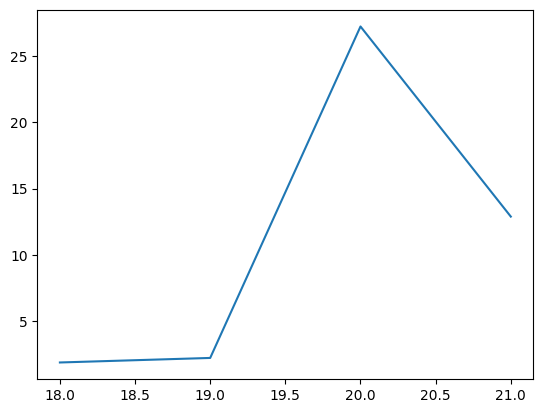

In [65]:
plt.plot(s['date_block_num'], s['item_cnt_month'])

<Axes: xlabel='avg_item_price', ylabel='item_cnt_month'>

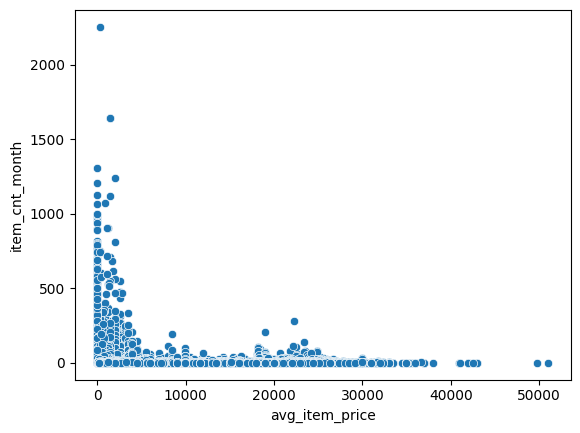

In [119]:
sns.scatterplot(x=lagged['avg_item_price'], y=lagged['item_cnt_month'])

(0.0, 10.0)

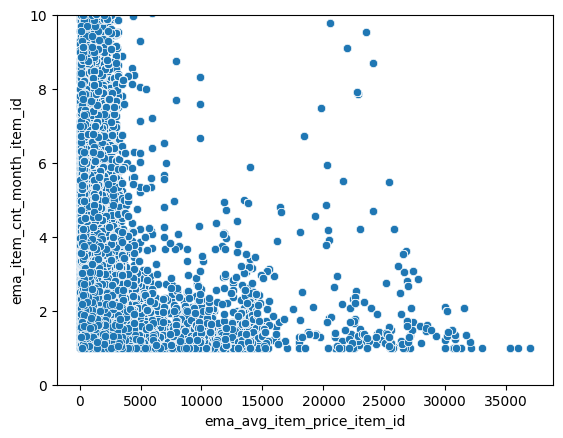

In [125]:
sns.scatterplot(x=lagged['ema_avg_item_price_item_id'], y=lagged['ema_item_cnt_month_item_id'])
plt.ylim(0,10)

In [129]:
arr=lagged.groupby(['ema_avg_item_price_item_id'])['ema_item_cnt_month_item_id'].mean().reset_index()

,ema_avg_item_price_item_id,ema_item_cnt_month_item_id
0,0.100000,3.323150
1,0.500000,1.000000
2,1.495789,2.595459
3,1.640625,2.058333
4,3.558651,5.940590
...,...,...
87321,32107.428571,1.000000
87322,32990.000000,1.000000
87323,35300.000000,1.000000
87324,35990.000000,1.000000


(0.0, 700.0)

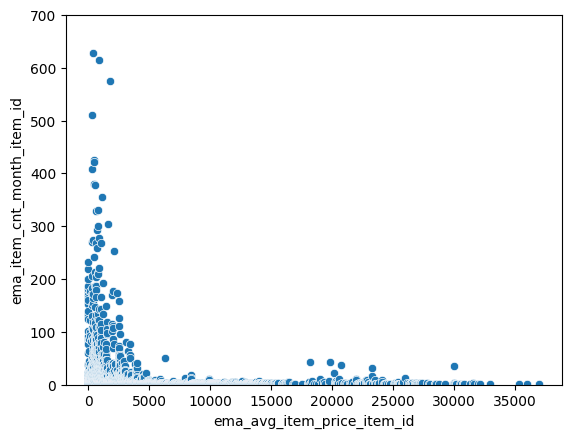

In [138]:
arr=lagged.groupby(['ema_avg_item_price_item_id'])['ema_item_cnt_month_item_id'].mean().reset_index()
sns.scatterplot(x=arr['ema_avg_item_price_item_id'], y=arr['ema_item_cnt_month_item_id'])
plt.ylim(0,700)

(0.0, 700.0)

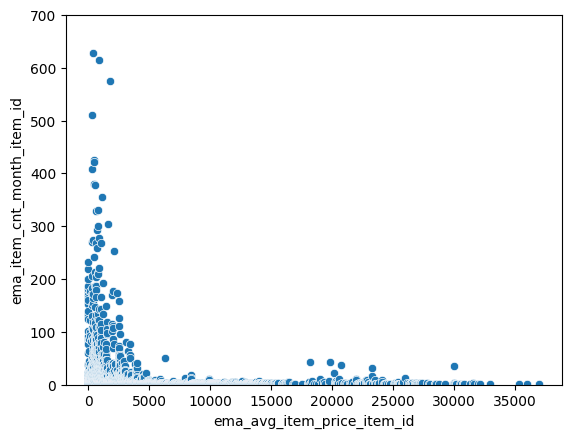

In [145]:
arr=lagged.groupby(['ema_avg_item_price_item_id'])['ema_item_cnt_month_item_id'].mean().reset_index()#.query('item_category_id == 2')
sns.scatterplot(x=arr['ema_avg_item_price_item_id'], y=arr['ema_item_cnt_month_item_id'])
plt.ylim(0,700)

In [152]:
m = lagged.groupby('item_category_name').agg({'avg_item_price':'mean'}).reset_index().sort_values(by='avg_item_price')
m

,item_category_name,avg_item_price
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",5.018596
50,Книги - Открытки,20.500000
82,Чистые носители (штучные),33.664392
66,"Подарки - Открытки, наклейки",71.469452
0,PC - Гарнитуры/Наушники,87.800000
...,...,...
14,Игровые консоли - PSVita,9298.433818
15,Игровые консоли - XBOX 360,11697.214060
11,Игровые консоли - PS3,12650.413492
16,Игровые консоли - XBOX ONE,20110.894948


(0.0, 700.0)

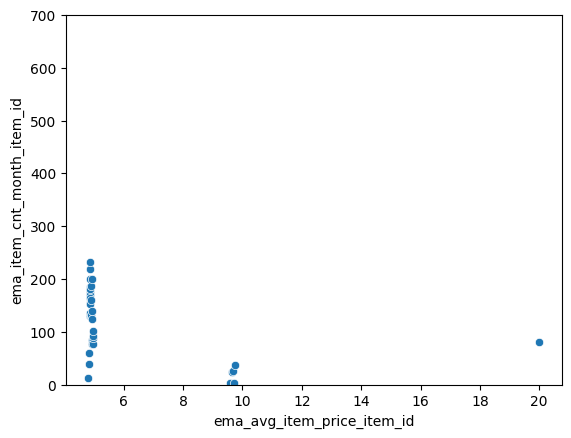

In [157]:

arr=lagged[lagged['item_category_name']=='Подарки - Сумки, Альбомы, Коврики д/мыши'].groupby(['ema_avg_item_price_item_id'])['ema_item_cnt_month_item_id'].mean().reset_index()#.query('item_category_id == 2')
sns.scatterplot(x=arr['ema_avg_item_price_item_id'], y=arr['ema_item_cnt_month_item_id'])
plt.ylim(0,700)

Columns to add - date_block_num_diff, EMAs, cat_diff
Columns to delete - may be lags